## Scratch notebook for testing

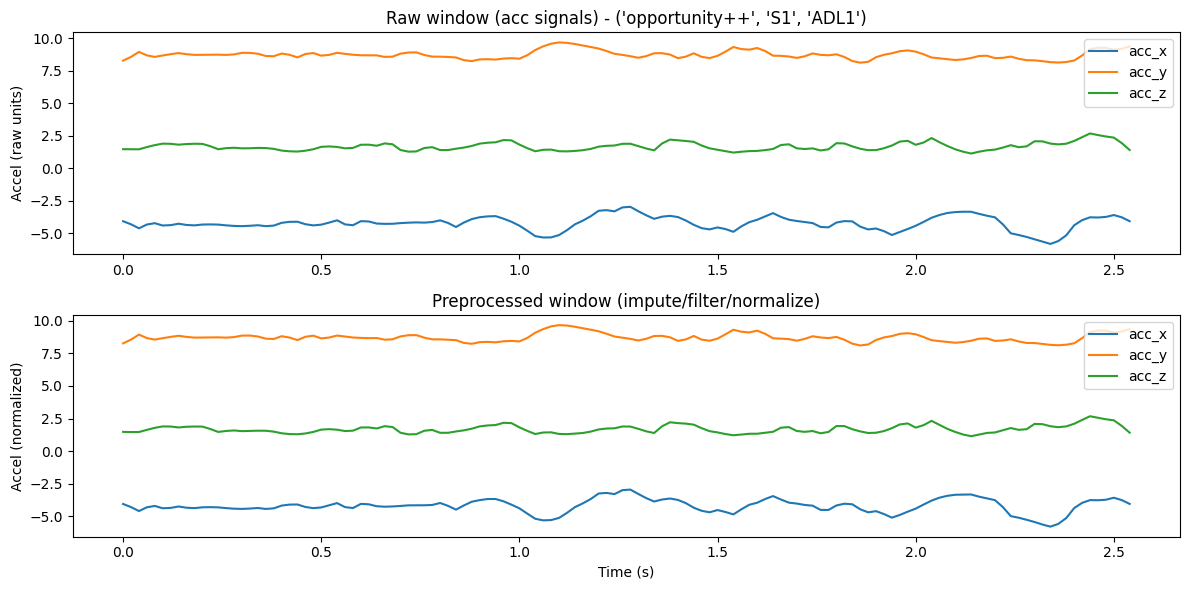

In [2]:
# Visualize one IMU window: raw vs preprocessed (impute/filter/normalize per configs/base.yaml)
# Streams a single session without building the full session index (fast):
# - scan only key columns to pick the first session
# - read just that session via pyarrow filter
# - plot raw vs preprocessed accelerometer signals

import yaml
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.dataset as ds

from imu_lm.data.windowing import compute_T_and_hop
from imu_lm.data.augmentations.preprocess import preprocess_window


def cfg_get(cfg, path, default=None):
    cur = cfg
    for key in path:
        if cur is None:
            return default
        if isinstance(cur, dict):
            cur = cur.get(key, default)
        else:
            cur = getattr(cur, key, default)
    return cur if cur is not None else default


# Load base config
cfg = yaml.safe_load(open("configs/base.yaml", "r"))
parquet_path = cfg_get(cfg, ["data", "loading", "dataset_path"])

dataset_col = cfg_get(cfg, ["data", "loading", "dataset_column"], "dataset")
subject_col = cfg_get(cfg, ["data", "loading", "subject_column"], "subject_id")
session_col = cfg_get(cfg, ["data", "loading", "session_column"], "session_id")
time_col = cfg_get(cfg, ["data", "loading", "time_column"], None)
label_col = cfg_get(cfg, ["data", "loading", "label_column"], "global_activity_id")
sensor_cols = cfg_get(cfg, ["data", "loading", "sensor_columns"], [])

# 1) Find a single session key via lightweight scan (no full index)
pa_ds = ds.dataset(parquet_path, format="parquet")
key_cols = [dataset_col, subject_col, session_col]
scanner = pa_ds.scanner(columns=key_cols, batch_size=100_000)
key = None
for batch in scanner.to_batches():
    if len(batch) == 0:
        continue
    ds_vals = batch[dataset_col].to_pylist()
    subj_vals = batch[subject_col].to_pylist()
    sess_vals = batch[session_col].to_pylist()
    if ds_vals:
        key = (str(ds_vals[0]), str(subj_vals[0]), str(sess_vals[0]))
        break
assert key is not None, "No sessions found in dataset"

# 2) Stream only that session's rows
cols = list(sensor_cols) + [label_col]
if time_col:
    cols.append(time_col)
cols.extend([dataset_col, subject_col, session_col])

filt = (
    (ds.field(dataset_col) == key[0])
    & (ds.field(subject_col) == key[1])
    & (ds.field(session_col) == key[2])
)
table = pa_ds.to_table(columns=cols, filter=filt)
df = table.to_pandas()

# 3) Take the first window
T, _ = compute_T_and_hop(cfg)
assert len(df) >= T, "Session shorter than one window"
X = df[sensor_cols].to_numpy(dtype=np.float32)
Xw = X[:T]

# 4) Preprocess (impute -> filter -> normalize) → [C, T]
Xproc = preprocess_window(Xw.copy(), cfg)
assert Xproc is not None, "Window was dropped by preprocessing"

# 5) Plot raw vs preprocessed (assumes canonical 50 Hz)
t_raw = np.arange(Xw.shape[0]) / 50.0
t_proc = np.arange(Xproc.shape[1]) / 50.0

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=False)
axes[0].plot(t_raw, Xw)
axes[0].set_title(f"Raw window (acc signals) - {key}")
axes[0].set_ylabel("Accel (raw units)")
axes[0].legend(sensor_cols, loc="upper right")

axes[1].plot(t_proc, Xproc.T)
axes[1].set_title("Preprocessed window (impute/filter/normalize)")
axes[1].set_ylabel("Accel (normalized)")
axes[1].legend(sensor_cols, loc="upper right")
axes[1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()


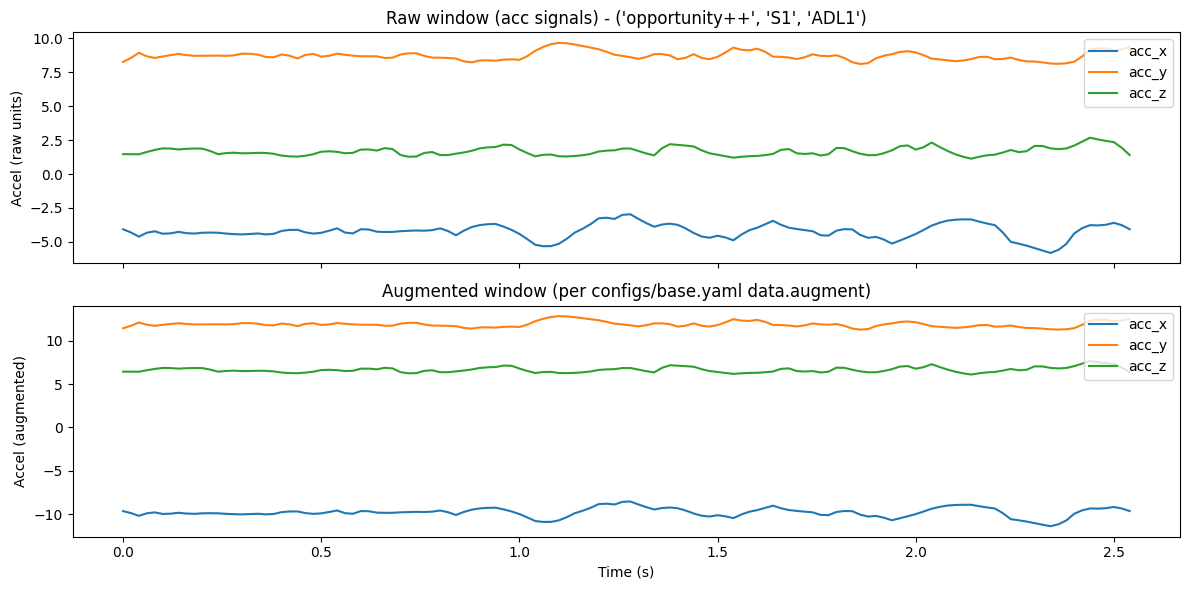

In [18]:
# Visualize raw vs augmented window (uses configs/base.yaml and imu_lm.data.augmentations.transform.apply_augment)
# This is fast: streams a single session and a single window.

import numpy as np
import matplotlib.pyplot as plt
import pyarrow.dataset as ds
import yaml

from imu_lm.data.augmentations.transform import apply_augment
from imu_lm.data.windowing import compute_T_and_hop


def cfg_get(cfg, path, default=None):
    cur = cfg
    for key in path:
        if cur is None:
            return default
        if isinstance(cur, dict):
            cur = cur.get(key, default)
        else:
            cur = getattr(cur, key, default)
    return cur if cur is not None else default


# Load config and dataset path
cfg = yaml.safe_load(open("configs/base.yaml", "r"))
parquet_path = cfg_get(cfg, ["data", "loading", "dataset_path"])

# Columns
sensor_cols = cfg_get(cfg, ["data", "loading", "sensor_columns"], [])
label_col = cfg_get(cfg, ["data", "loading", "label_column"], "global_activity_id")
time_col = cfg_get(cfg, ["data", "loading", "time_column"], None)
dataset_col = cfg_get(cfg, ["data", "loading", "dataset_column"], "dataset")
subject_col = cfg_get(cfg, ["data", "loading", "subject_column"], "subject_id")
session_col = cfg_get(cfg, ["data", "loading", "session_column"], "session_id")

# Find a session key quickly (scan only key columns)
pa_ds = ds.dataset(parquet_path, format="parquet")
key_cols = [dataset_col, subject_col, session_col]
scanner = pa_ds.scanner(columns=key_cols, batch_size=100_000)
key = None
for batch in scanner.to_batches():
    if len(batch) == 0:
        continue
    ds_vals = batch[dataset_col].to_pylist()
    subj_vals = batch[subject_col].to_pylist()
    sess_vals = batch[session_col].to_pylist()
    if ds_vals:
        key = (str(ds_vals[0]), str(subj_vals[0]), str(sess_vals[0]))
        break
assert key is not None, "No sessions found in dataset"

# Fetch that session's rows (only needed columns)
cols = list(sensor_cols) + [label_col]
if time_col:
    cols.append(time_col)
cols.extend([dataset_col, subject_col, session_col])

filt = (
    (ds.field(dataset_col) == key[0])
    & (ds.field(subject_col) == key[1])
    & (ds.field(session_col) == key[2])
)
table = pa_ds.to_table(columns=cols, filter=filt)
df = table.to_pandas()

# Take first window
T, _ = compute_T_and_hop(cfg)
assert len(df) >= T, "Session shorter than one window"
X = df[sensor_cols].to_numpy(dtype=np.float32)
Xw = X[:T]

# Apply augmentations per config
X_aug = apply_augment(Xw.copy(), cfg)

# Plot
fs = 50.0
tr = np.arange(Xw.shape[0]) / fs
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(tr, Xw)
axes[0].set_title(f"Raw window (acc signals) - {key}")
axes[0].set_ylabel("Accel (raw units)")
axes[0].legend(sensor_cols, loc="upper right")

axes[1].plot(tr, X_aug)
axes[1].set_title("Augmented window (per configs/base.yaml data.augment)")
axes[1].set_ylabel("Accel (augmented)")
axes[1].legend(sensor_cols, loc="upper right")
axes[1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()


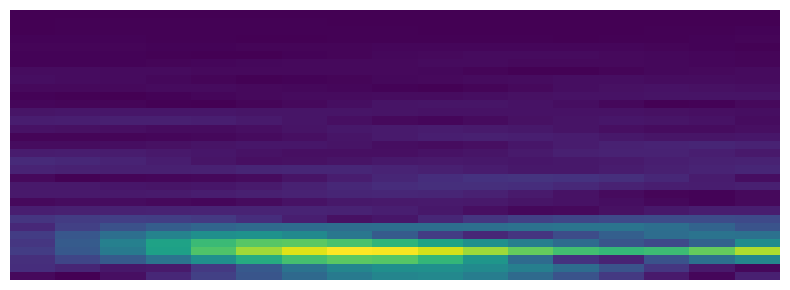

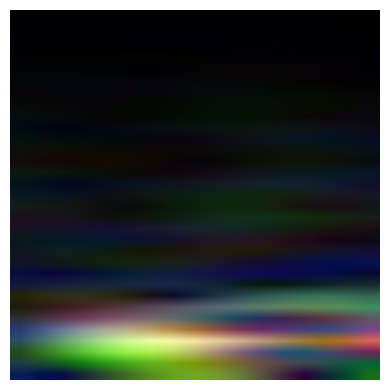

In [2]:
# # Visualize spectrogram for one IMU window (config-driven torch.stft)
# # - Streams one session quickly (no full index), takes first window.
# # - Uses data.augment.spectrogram knobs (n_fft, win_length, hop_length, center).
# # - If return_image=True in config, also shows the PNG produced by stft_encode.

# import numpy as np
# import matplotlib.pyplot as plt
# import pyarrow.dataset as ds
# import torch
# import yaml
# from IPython.display import Image, display

# from imu_lm.data.windowing import compute_T_and_hop
# from imu_lm.data.augmentations.spectrogram import stft_encode


# def cfg_get(cfg, path, default=None):
#     cur = cfg
#     for key in path:
#         if cur is None:
#             return default
#         if isinstance(cur, dict):
#             cur = cur.get(key, default)
#         else:
#             cur = getattr(cur, key, default)
#     return cur if cur is not None else default


# # Load config and dataset path
# cfg = yaml.safe_load(open("configs/base.yaml", "r"))
# parquet_path = cfg_get(cfg, ["data", "loading", "dataset_path"])

# sensor_cols = cfg_get(cfg, ["data", "loading", "sensor_columns"], [])
# label_col = cfg_get(cfg, ["data", "loading", "label_column"], "global_activity_id")
# time_col = cfg_get(cfg, ["data", "loading", "time_column"], None)
# dataset_col = cfg_get(cfg, ["data", "loading", "dataset_column"], "dataset")
# subject_col = cfg_get(cfg, ["data", "loading", "subject_column"], "subject_id")
# session_col = cfg_get(cfg, ["data", "loading", "session_column"], "session_id")

# # Find a session key quickly (scan only key columns)
# pa_ds = ds.dataset(parquet_path, format="parquet")
# key_cols = [dataset_col, subject_col, session_col]
# scanner = pa_ds.scanner(columns=key_cols, batch_size=100_000)
# key = None
# for batch in scanner.to_batches():
#     if len(batch) == 0:
#         continue
#     ds_vals = batch[dataset_col].to_pylist()
#     subj_vals = batch[subject_col].to_pylist()
#     sess_vals = batch[session_col].to_pylist()
#     if ds_vals:
#         key = (str(ds_vals[0]), str(subj_vals[0]), str(sess_vals[0]))
#         break
# assert key is not None, "No sessions found in dataset"

# # Fetch that session's rows (only needed columns)
# cols = list(sensor_cols) + [label_col]
# if time_col:
#     cols.append(time_col)
# cols.extend([dataset_col, subject_col, session_col])

# filt = (
#     (ds.field(dataset_col) == key[0])
#     & (ds.field(subject_col) == key[1])
#     & (ds.field(session_col) == key[2])
# )
# table = pa_ds.to_table(columns=cols, filter=filt)
# df = table.to_pandas()

# # Take first window
# T, _ = compute_T_and_hop(cfg)
# assert len(df) >= T, "Session shorter than one window"
# X = df[sensor_cols].to_numpy(dtype=np.float32)
# Xw = X[:T]

# from imu_lm.data.augmentations.preprocess import preprocess_window

# # Xw is [T, C] numpy from your parquet window
# Xproc = preprocess_window(Xw.copy(), cfg)      # -> [C, T] (per your preprocess code)
# assert Xproc is not None, "Window dropped by preprocessing"

# x_ct = torch.from_numpy(np.ascontiguousarray(Xproc)).float()  # [C, T]
# spec_out = stft_encode(x_ct, cfg)
# if isinstance(spec_out, tuple):
#     spec, png_bytes = spec_out
# else:
#     spec, png_bytes = spec_out, None

# # Plot first channel spectrogram (magnitude)
# spec_np = spec[0].cpu().numpy()
# fig, ax = plt.subplots(figsize=(8, 3))
# ax.imshow(spec_np, aspect="auto", origin="lower")
# ax.axis("off")
# plt.tight_layout()
# plt.show()

# # Show PNG if available (axes-free rendering from stft_encode)
# if png_bytes is not None:
#     display(Image(png_bytes))

import numpy as np
import matplotlib.pyplot as plt
import pyarrow.dataset as ds
import torch
import yaml

from imu_lm.data.windowing import compute_T_and_hop
from imu_lm.data.augmentations.spectrogram import stft_encode
from imu_lm.data.augmentations.preprocess import preprocess_window
import torch.nn.functional as F


def cfg_get(cfg, path, default=None):
    cur = cfg
    for key in path:
        if cur is None:
            return default
        cur = cur.get(key, default) if isinstance(cur, dict) else getattr(cur, key, default)
    return cur if cur is not None else default


cfg = yaml.safe_load(open("configs/base.yaml", "r"))
parquet_path = cfg_get(cfg, ["data", "loading", "dataset_path"])

sensor_cols  = cfg_get(cfg, ["data", "loading", "sensor_columns"], [])
label_col    = cfg_get(cfg, ["data", "loading", "label_column"], "global_activity_id")
time_col     = cfg_get(cfg, ["data", "loading", "time_column"], None)
dataset_col  = cfg_get(cfg, ["data", "loading", "dataset_column"], "dataset")
subject_col  = cfg_get(cfg, ["data", "loading", "subject_column"], "subject_id")
session_col  = cfg_get(cfg, ["data", "loading", "session_column"], "session_id")

pa_ds = ds.dataset(parquet_path, format="parquet")
key_cols = [dataset_col, subject_col, session_col]
scanner = pa_ds.scanner(columns=key_cols, batch_size=100_000)

key = None
for batch in scanner.to_batches():
    if len(batch) == 0:
        continue
    key = (str(batch[dataset_col][0].as_py()),
           str(batch[subject_col][0].as_py()),
           str(batch[session_col][0].as_py()))
    break
assert key is not None

cols = list(sensor_cols) + [label_col] + [dataset_col, subject_col, session_col]
if time_col:
    cols.append(time_col)

filt = (
    (ds.field(dataset_col) == key[0]) &
    (ds.field(subject_col) == key[1]) &
    (ds.field(session_col) == key[2])
)

df = pa_ds.to_table(columns=cols, filter=filt).to_pandas()

T, _ = compute_T_and_hop(cfg)
Xw = df[sensor_cols].to_numpy(np.float32)[:T]

Xproc = preprocess_window(Xw.copy(), cfg)   # [C,T]
assert Xproc is not None

x_ct = torch.from_numpy(np.ascontiguousarray(Xproc)).float()

out = stft_encode(x_ct, cfg)

if isinstance(out, tuple):
    spec, img = out          # spec: [C,F,TT], img: [3,F,TT]
else:
    spec, img = out, None

# Visualize spec channel 0
plt.figure(figsize=(8, 3))
plt.imshow(spec[0].cpu().numpy(), aspect="auto", origin="lower")
plt.axis("off")
plt.tight_layout()
plt.show()

# Visualize image tensor if present
if img is not None:
    img_resized = F.interpolate(img.unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False)
    img_resized = img_resized.squeeze(0)  # [3,224,224]
 
    plt.figure(figsize=(4, 4))
    plt.imshow(img_resized.permute(1, 2, 0).cpu().numpy(), aspect="auto", origin="lower")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


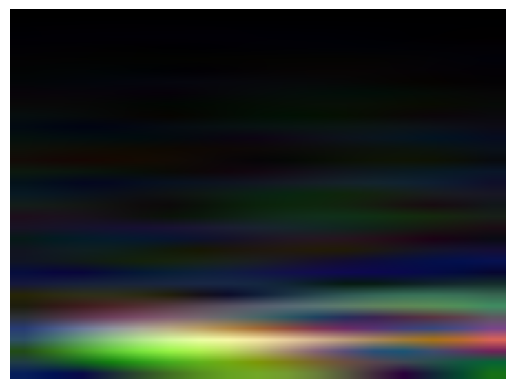

img_resized stats: 1.8196153632743517e-06 0.9975793957710266 0.1295774132013321
img_hf stats: -2.1171891689300537 2.417764902114868 -1.412224531173706


In [3]:
hf_mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
hf_std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
 
img_resized = F.interpolate(img.unsqueeze(0), size=(224,224), mode="bilinear", align_corners=False).squeeze(0)  # [3,224,224]
img_hf = (img_resized - hf_mean) / hf_std  # normalized
 
# for visualization, unnormalize back to 0-1
vis = (img_hf * hf_std + hf_mean).permute(1,2,0).cpu().numpy()
plt.imshow(vis, aspect="auto", origin="lower"); plt.axis("off"); plt.show()
 
print("img_resized stats:", img_resized.min().item(), img_resized.max().item(), img_resized.mean().item())
print("img_hf stats:", img_hf.min().item(), img_hf.max().item(), img_hf.mean().item())